# Exercise 4: Short-time Fourier Transform

Doing this exercise you will learn about the concept of the main lobe width of the spectrum of a window and you will better understand the short-time Fourier transform (STFT). You will also use the STFT to extract basic rhythm related information from an audio signal, implementing an onset detection function, which is one of the rhythm descriptors often used in music information retrieval to detect onsets of acoustic events.

There are four parts in this exercise. 1) Extracting the main lobe of the spectrum of a window, 2) Measuring noise in the reconstructed signal using the STFT model, 3) Computing band-wise energy envelopes of a signal, 4) Computing an onset detection function.


### Relevant Concepts

__Main lobe of the spectrum of a window:__
The width of the main lobe of the magnitude spectrum of a window is an important characteristic used in deciding which window type is best for the analysis of an audio excerpt. There exists a tradeoff between the main lobe width and the side lobe attenuation. Typically for windows with a narrower main lobe, the side lobes are less attenuated.
An interesting fact is that changing the length of a window $M$ doesn't affect the main lobe width of the spectrum of the window in samples. Note that if you use zero-padding for computing the spectrum of a window, the main lobe width will be multiplied by the zero-padding factor.

__Fast Fourier Transform (FFT):__
An efficient way to compute the discrete Fourier transform of a signal is the fast Fourier transform, FFT. The FFT algorithm  factorizes the DFT matrix in order to exploit the symmetries in the DFT equation. FFT computation is specially very efficient when the FFT size is a power of 2. Therefore, whenever possible we use an FFT size that is a power of 2.

__Energy of a signal:__ The energy of a signal $x[n]$ of length $N$ can be computed in the discrete time domain as follows:
\begin{equation}
E=\overset{N-1}{\underset{n=0}{\sum}}\left|x\left[n\right]\right|^{2}
\end{equation}

__Energy in a frequency band:__ Given the DFT spectrum of the signal $X[k]$, the energy $E$ in a specific frequency band spanning the bin index $k_1$ to $k_2$ can be computed as:

\begin{equation}
E=\overset{k_{2}}{\underset{k=k_{1}}{\sum}}\left|X\left[k\right]\right|^{2}
\end{equation}

Note that in this computation the $X[k]$ values are not in decibels (dB). The `stftAnal()` function returns magnitude spectra in dB scale, which should be converted to linear scale before the energy computation. Once the energy is computed it can be converted back to the dB scale as:

\begin{equation}
E_{dB}= 10\,\log_{10}(E)
\end{equation}

__Signal to noise ratio (SNR):__
Signal to noise ratio (SNR) is a frequently used measure to quantify the amount of noise present/added in a signal. In the context of this exercise it can be computed in decibels (dB) as:

\begin{equation}
\mathrm{SNR} = 10\,\log_{10}\left(\frac{E_{\mathrm{signal}}}{E_{\mathrm{noise}}}\right)
\end{equation}

where, $E_{\mathrm{signal}}$ and $E_{\mathrm{noise}}$ are the energy of the signal and noise respectively.

For our case of analysis and synthesis using a specific model (for example, STFT) noise can be thought of as the difference between the input signal and the output signal of the model.

__Onset detection function:__
An onset detection function (ODF) refers to a continuous function (one value per audio frame) often used for detecting acoustic events in an audio stream. In music information retrieval (MIR), ODFs are typically used for detecting onsets of musical notes and percussion strokes. An ODF generally has high values at the onsets of acoustic events. A simple ODF can be computed by taking the difference between the energy values of consecutive frames, as shown below:

\begin{equation}
O(l) = E(l) - E(l-1) ,\,\,\,\,\, l \geq 1
\end{equation}

where, $O(l)$ is the ODF computed at frame index $l$ and $E$ is the energy of the signal in a particular frequency band in decibels (dB). Often, multiple ODFs are computed with different frequency bands across the spectrum.

In order to detect only the onsets of the events and not the offsets, it is a common practice to half wave rectify the ODF and obtain $\bar{O}(l)$. Half wave rectification of the ODF is given by:

 \begin{equation}
 \bar{O}(l)=\begin{cases}
 \begin{array}{c}
 O(l), \, \mathrm{if} \,\,O(l)>0\\
 \,\,\,\,0, \,\,\,\,\, \mathrm{if} \,\, O(l)\leq0
 \end{array}\end{cases}
 \end{equation}

## Part 1 - Extracting the main lobe of the spectrum of a window

The function `extract_main_lobe()` should extract the main lobe of the magnitude spectrum of a window given a window type, `window`, and its length, `M`. The function should return the samples corresponding to the main lobe in decibels (dB).

To compute the spectrum you should take the FFT size (`N`) to be 8 times the window length (`N = 8*M`) (For this part, `N` does not need to be a power of 2).

The input arguments to the function are the window type (`window`) and the length of the window (`M`). The function should return a numpy array containing the samples corresponding to the main lobe of the window. In the returned numpy array you should include the samples corresponding to both the local minimas across the main lobe.

The possible window types that you can expect as input are rectangular (`'boxcar'`), `'hamming'` or `'blackmanharris'`.

NOTE: You can approach this task by writing code to find the indices of the local minimas across the main lobe.

_Tip:_ `log10(0)` is not well defined, so its a common practice to add a small value such as `eps = 1e-16` to the magnitude spectrum before computing it in dB. This is optional and will not affect your answers.
If you find it difficult to concatenate the two halves of the main lobe, you can first center the spectrum using `fftshift()` and then compute the indexes of the minimas around the main lobe.

In [33]:
import numpy as np
from scipy.signal import get_window
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt
eps = np.finfo(float).eps
from smstools.models import stft
from smstools.models import utilFunctions as UF
from smstools.models.utilFunctions import wavread

In [34]:
# E4 - 1.1: Complete function extract_main_lob()

def extract_main_lobe(window, M, N):
    """Extract the main lobe of the magnitude spectrum of a window, given a window type and its length.

    Args:
        window (str): Window type to be used (either rectangular ('boxcar'), 'hamming' or 'blackmanharris')
        M (int): length of the window to be used
        N (int): size of FFT

    Results:
        np.array: an array containing the main lobe of the magnitude spectrum of the window in decibels (dB).
    """

    w = get_window(window, M)         # get the window

    ### Your code here
    W = np.fft.fft(w,N)
    shift_W = np.fft.fftshift(W)

    mX = np.abs(shift_W)
    mX_db = 20*np.log10(mX + eps)

    centro = N//2

    right = centro
    for i in range(centro + 1, N -1):
        if mX[i] < mX[i-1] and mX[i]< mX[i+1]:
            right = i
            break
    if right == centro:
        right = N - 1

    dist = right - centro

    left = centro - dist

    return mX_db[left:right+1], mX_db, left, right


Test cases for the function `extract_main_lobe()`:

_Test case 1:_ If you run your code using `window = 'blackmanharris'`, `M = 100` and `N = 800`, the output numpy array should contain 65 samples.

_Test case 2:_ If you run your code using `window = 'boxcar'`, `M = 120` and `N = 960`, the output numpy array should contain 17 samples.

_Test case 3:_ If you run your code using `window = 'hamming`, `M = 256`, and `N = 2048`, the output numpy array should contain 33 samples.

To understand better the result you can plot the magnitude spectrum of the window and mark the boundaries of the main lobe.

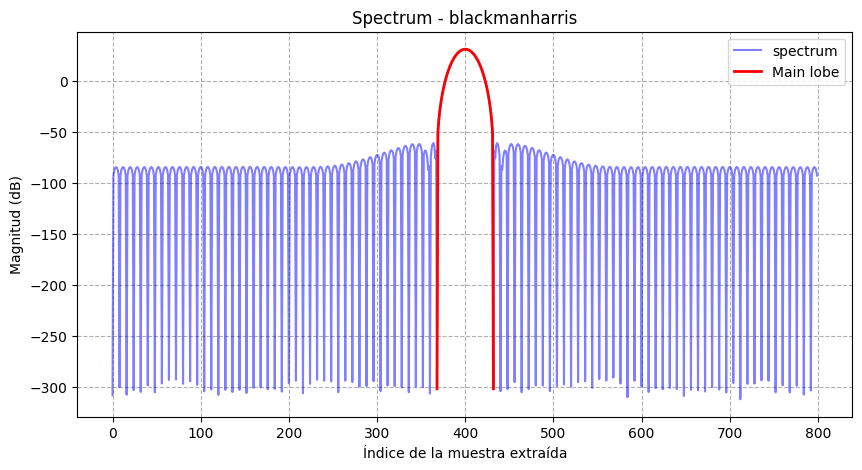

Número de muestras extraídas: 65


In [35]:
# E4 - 1.2: Call extract_main_lobe() with the 3 test cases mentioned and plot the magnitude spectra of the windows with
# the location of the main-lobe boundaries. Compute and explain the normalized main-lobe width (dividing by the
# zero-padding factor), comparing it with the values presented in the theory.

### Your code here
#test case 1
main_lobe1, spectrum1, l1, r1 = extract_main_lobe(window='blackmanharris',M=100,N=800)

plt.figure(figsize=(10, 5))
plt.plot(spectrum1, color='blue', alpha=0.5, label='spectrum') #plot side lobes
plt.plot(range(l1, r1+1), main_lobe1, 'r-', linewidth=2, label='Main lobe') #plot the main lobe

# 3. Formato
plt.title('Spectrum - blackmanharris')
plt.xlabel('Índice de la muestra extraída')
plt.ylabel('Magnitud (dB)')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

print(f"Número de muestras extraídas: {len(main_lobe1)}")



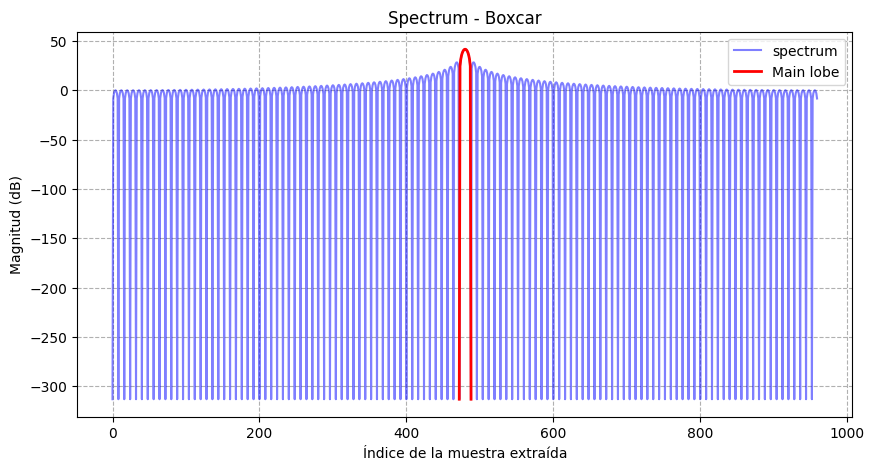

Número de muestras extraídas: 17


In [36]:
#test case 2

main_lobe2, spectrum2, l2, r2 = extract_main_lobe(window='boxcar',M=120,N=960)

plt.figure(figsize=(10, 5))
plt.plot(spectrum2, color='blue', alpha=0.5, label='spectrum') #plot side lobe
plt.plot(range(l2, r2+1), main_lobe2, 'r-', linewidth=2, label='Main lobe') #plot main lobe

# 3. Formato
plt.title('Spectrum - Boxcar')
plt.xlabel('Índice de la muestra extraída')
plt.ylabel('Magnitud (dB)')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

print(f"Número de muestras extraídas: {len(main_lobe2)}")

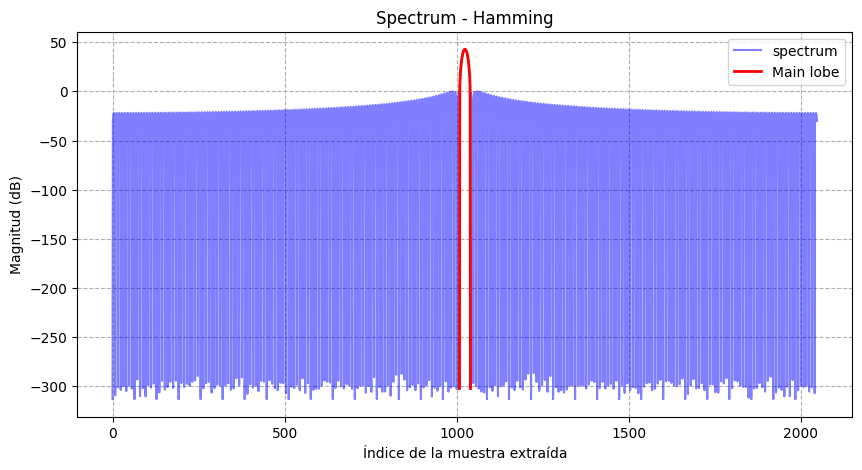

Número de muestras extraídas: 33


In [37]:
#test case 3


main_lobe3, spectrum3, l3, r3 = extract_main_lobe(window='hamming',M=256,N=2048)

plt.figure(figsize=(10, 5))
plt.plot(spectrum3, color='blue', alpha=0.5, label='spectrum')
plt.plot(range(l3, r3+1), main_lobe3, 'r-', linewidth=2, label='Main lobe')

# 3. Formato
plt.title('Spectrum - Hamming')
plt.xlabel('Índice de la muestra extraída')
plt.ylabel('Magnitud (dB)')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

print(f"Número de muestras extraídas: {len(main_lobe3)}")

## Part 2 - Measuring noise in the reconstructed signal using the STFT model

The function `compute_snr()` should measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model. Use SNR (signal to noise ratio) in dB to quantify the amount of noise.
Use the `stft()` function in `stft.py` to do an analysis followed by a synthesis of the input signal.

Use the time domain energy definition to compute the SNR. With the input signal and the obtained output, compute two different SNR values for the following cases:

1. `SNR1`: Over the entire length of the input and the output signals.
2. `SNR2`: For the segment of the signals left after discarding `M` samples from both the start and the end, where `M` is the analysis window length.

Note that the computations are done after STFT analysis and synthesis. The input arguments to the function are the wav file name including the path (`input_file`), window  type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a python tuple of both the SNR values in decibels. Both SNR1 and SNR2 are float values.

In [38]:
# E4 - 2.1: Complete function compute_snr()

def compute_snr(input_file, window, M, N, H):
    """Measure the amount of distortion introduced during the analysis and synthesis of a signal using the STFT model.

    Args:
        input_file (str): wav file name including the path
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window length (odd positive integer)
        N (int): fft size (power of two, > M)
        H (int): hop size for the stft computation

    Result:
        tuple with the signal to noise ratio over the whole sound and of the sound without the begining and end.
    """
    ### your code here
    w = get_window(window, M)
    fs, audio = wavread(input_file)

    if len(audio.shape) > 1:
        audio = audio[:, 0]

    mX, pX = stft.stftAnal(audio, w, N, H)
    stft_resynthesized = stft.stftSynth(mX, pX, M, H)

    min_len = min(len(audio), len(stft_resynthesized))
    audio = audio[:min_len]
    stft_resynthesized = stft_resynthesized[:min_len]

    noise = audio - stft_resynthesized

    #SNR1
    energy_signal = np.sum(audio**2)
    energy_noise = np.sum(noise**2)

    SNR1 = 10*np.log10(energy_signal/(energy_noise+eps))

    #SNR2
    #nos quedamos solo una parte de la señal
    
    segment = audio[M:-M]
    noise_segment = noise[M:-M]

    energy_signal_segment = np.sum(segment**2)
    energy_noise_segment = np.sum(noise_segment**2)

    SNR2 = 10*np.log10(energy_signal_segment/(energy_noise_segment+eps))


    return (float(SNR1), float(SNR2))





    


Test cases for the function `compute_snr()`:

_Test case 1:_ If you run your code using `piano.wav` file with `'blackman'` window, `M = 513`, `N = 2048` and
`H = 128`, the output SNR values should be around: `(67.57748352378475, 86.35716169253175)`.

_Test case 2:_ If you run your code using `sax-phrase-short.wav` file with `'hamming'` window, `M = 512`,
`N = 1024` and `H = 64`, the output SNR values should be around: `(89.510506656299285, 306.18696700251388)`.

_Test case 3:_ If you run your code using `rain.wav` file with `'hann'` window, `M = 1024`, `N = 2048` and
`H = 128`, the output SNR values should be around: `(74.631476225366825, 304.26918192997738)`.

Due to precision differences on different machines/hardware, compared to the expected SNR values, your output values can differ substantially.

In [39]:
# E4 - 2.2: Call the function compute_snr() for the 3 test cases mentioned, explain the results

### Your code here
#test case 1

test1 = compute_snr(input_file = "C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/piano.wav", window= 'blackman', M = 513, N = 2048, H = 128)

test2 = compute_snr(input_file = "C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/sax-phrase-short.wav", window = 'hamming', M = 512, N = 1024, H= 64)

test3 = compute_snr(input_file = "C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/rain.wav", window = 'hann', M = 1024, N = 2048, H= 128)

print(test1)
print(test2)
print(test3)

(67.54018457558887, 86.3571603597585)
(89.5105062952166, 187.3932291313436)
(74.63147527762122, 182.63673954896115)


## Part 3 - Computing band-wise energy envelopes of a signal

The function `compute_eng_env()` should compute band-wise energy envelopes of a given audio signal using the STFT.

Consider two frequency bands, low and high. The low frequency band is the set of frequencies between 0 and 3000 Hz and the high frequency band is the set of frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). At a given frame, the value of the energy envelope of a band can be computed as the sum of squared values of all the frequency coefficients in that band. Then you should compute the energy envelopes in decibels.

The input arguments are the wav file name including the path (`input_file`), window type (`window`), window length (`M`), FFT size (`N`) and hop size (`H`). The function should return a numpy array with two columns, where the first column is the energy envelope of the low frequency band and the second column is that of the high frequency band.

Use `stftAnal()` function from `stft.py` module to obtain the magnitude spectra for all the audio frames of the input sound. Then compute the energy values for each frequency band specified. While calculating frequency bins for each frequency band, consider only the bins that are within the specified frequency range. For example, for the low frequency band consider only the bins with frequency > 0 Hz and < 3000 Hz (you can use `np.where()` to find those bin indexes). This way you also remove the DC offset of the signal in energy envelope computation. The frequency corresponding to the bin index `k` can be computed as `k*fs/N`, where `fs` is the sampling rate of the signal.

In [40]:
# E4 - 3.1: Complete function compute_eng_env()

def compute_eng_env(input_file, window, M, N, H):
    """Compute band-wise energy envelopes of a given audio signal using the STFT.

    Args:
        input_file (string): input sound file (monophonic with sampling rate of 44100)
        window (string): analysis window type (choice of rectangular, triangular, hanning,
                hamming, blackman, blackmanharris)
        M (integer): analysis window size (odd positive integer)
        N (integer): FFT size (power of 2, such that N > M)
        H (integer): hop size for the stft computation

    Result:
        np.array: magnitude spectra of sound (2D array)
        np.array: 2D numpy array with energy envelope of band 0 < f < 3000 Hz (in dB) in first column, [:,0]
        np.array: energy envelope of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """

    ### your code here

    fs, audio = wavread(input_file)
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    w = get_window(window,M)

    mX, pX = stft.stftAnal(audio,w,N,H)
    #dB to energy
    energy = 10**(mX/10)
    

    #bins 
    k = np.arange(N//2 + 1)
    frqs_bins = k * fs / N

    #bandas de frecuencia
    fq_low = np.where((frqs_bins > 0) & (frqs_bins < 3000))[0]
    fq_high = np.where((frqs_bins > 3000) & (frqs_bins < 10000))[0]
    #son para comprobar en los test case que cuando llama a la funcion devuelve lo que quiero(no son necesarios)
    print(f"Banda baja: {fq_low[0]} a {fq_low[-1]} (Total: {len(fq_low)})")
    print(f"Banda alta: {fq_high[0]} a {fq_high[-1]} (Total: {len(fq_high)})")

    #suma energy en todas las bandas
    energy_low = np.sum(energy[:, fq_low], axis=1)
    energy_high = np.sum(energy[:, fq_high], axis=1)
    
    #pasar a dB
    env_low_energy = 10*np.log10(energy_low+eps)
    env_high_energy = 10*np.log10(energy_high+eps)

    return mX, np.column_stack((env_low_energy, env_high_energy))




    




Test cases for the function `compute_eng_env()`:

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input.
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency
band span from 70 to 232 (163 samples).

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input.
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency
band span from 279 to 928 (650 samples).

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the band-wise energy envelope and its characteristics you can plot the envelopes together with the spectrogram of the signal. You can use `matplotlib` plotting library for this purpose. To visualize the spectrogram of a signal, a good option is to use the function `colormesh()` (you can reuse the code in
`lectures/4-STFT/plots-code/spectrogram.py`). Either overlay the envelopes on the spectrogram
or plot them in a different subplot. Make sure you use the same range of the x-axis for both the spectrogram and the energy envelopes.

You can clearly notice the sharp attacks and decay of the piano notes for test case 1. You can compare this with the output from test case 2 that uses a larger window. You can infer the influence of window size on sharpness of the note attacks.

In [41]:
# E4 - 3.2: Call the function compute_eng_env() and plot the envelopes together with the
# spectrogram of the signal

### Your code here
#test case 1 (x)
x = compute_eng_env("C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/piano.wav", 'blackman', 513, 1024, 128)


Banda baja: 1 a 69 (Total: 69)
Banda alta: 70 a 232 (Total: 163)


In [42]:
#test case 2 (y)

y = compute_eng_env(input_file = "C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/piano.wav", window= 'blackman', M = 2047, N = 4096, H = 128)

Banda baja: 1 a 278 (Total: 278)
Banda alta: 279 a 928 (Total: 650)


In [43]:
#test case 3 (z)
z = compute_eng_env(input_file = "C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/sax-phrase-short.wav", window = 'hamming', M = 513, N = 2048, H= 256)

Banda baja: 1 a 139 (Total: 139)
Banda alta: 140 a 464 (Total: 325)


## Part 4 - Computing onset detection function

The function `compute_odf()` should compute a simple onset detection function (ODF) using the STFT. It should compute two ODFs one for each of the frequency bands, low and high. The low frequency band is the set of all the frequencies between 0 and 3000 Hz and the high frequency band is the set of all the frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases).

Start with an initial condition of `ODF(0) = 0` in order to make the length of the ODF same as that of the energy envelope. Remember to apply a half wave rectification on the ODF.

The input arguments to the function are the wav file name including the path (`input_file`), window
type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a numpy
array with two columns, where the first column is the ODF computed on the low frequency band and the
second column is the ODF computed on the high frequency band.

Use `stftAnal()` to obtain the magnitude spectra for all the audio frames. Then compute the band-wise energy envelope for each frequency band specified. Finally compute the half wave rectify version of ODF from each energy envelope.


In [47]:
# E4 4.1: Complete function compute_odf()

def compute_odf(input_file, window, M, N, H):
    """Compute a simple onset detection function (ODF) using the STFT.

    Args:
        input_file (str): input sound file (monophonic with sampling rate of 44100)
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window size (odd integer value)
        N (int): fft size (power of two, bigger or equal than than M)
        H (int): hop size for the STFT computation

    Result:
            np.array: magnitude spectra of sound (2D array)
            np.array: D numpy array with ODF computed in band 0 < f < 3000 Hz (in dB) in first column, [:,0]
            np.array: ODF computed of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """

    ### your code here
    fs, audio = wavread(input_file)
    if audio.ndim > 1: audio = audio[:, 0]
    w = get_window(window, M)
    
    # Obtenemos mX (espectro) y pX (fase)
    mX, pX = stft.stftAnal(audio, w, N, H)
    #sabemos que la funcion devuelve dos cosas pero solo necesito envelope por eso _
    _ , envelope = compute_eng_env(input_file,window,M,N,H)
    linear_envelope = 10**(envelope/10)

    diff_low = np.diff(linear_envelope[:,0])
    #con el 0 recuperamos la longitud original
    odf_low = np.insert(diff_low,0,0)
    #nos quedamos solo con la parte positiva
    odf_low = np.maximum(0,odf_low)

    #hacemos los mismo para la parte de high frequencies
    diff_high = np.diff(linear_envelope[:,1])
    #con el 0 recuperamos la longitud original
    odf_high = np.insert(diff_high,0,0)
    #nos quedamos solo con la parte positiva
    odf_high = np.maximum(0,odf_high)



    return mX, np.column_stack((odf_low,odf_high))





Test cases for the function `compute_odf()`:

_Test case 1:_ Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input.
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency
band span from 70 to 232 (163 samples).

_Test case 2:_ Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input.
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency
band span from 279 to 928 (650 samples).

_Test case 3:_ Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high
frequency band span from 140 to 464 (325 samples).

To get a better understanding of the ODFs and their characteristics you can plot the ODF functions together with the spectrogram of the signal. Use the same plotting than in the previos part.

In order to identify the actual onsets of a signal you would need to find the peaks, local maxima, of the ODF functions using a magnitude threshold. Which of the 2 ODFs (low or high frequencies) would be most useful? What would be the right threshold for all 3 cases? Could you find a single threshold to be used for all 3 cases?

For test case 1, you should clearly see that the ODFs have sharp peaks at the onset of the piano notes. You should notice 5 peaks that are above 10dB value in the ODF computed on the high frequency band.

Banda baja: 1 a 69 (Total: 69)
Banda alta: 70 a 232 (Total: 163)


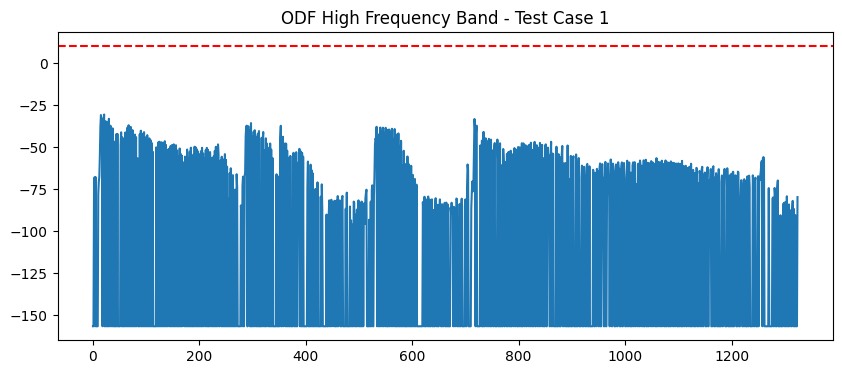

In [ ]:
# E4 - 4.2: Call the function compute_odf() for the 3 test cases and plot the ODF functions together with the
# spectrogram of the signal.

### Your code here
#test case 1
mX, odf = compute_odf("C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/piano.wav", 'blackman', 513, 1024, 128)

# Ahora puedes graficar sin errores
plt.figure(figsize=(10, 4))
plt.plot(10 * np.log10(odf[:, 1] + eps)) # ODF Banda Alta en dB
plt.axhline(y=10, color='r', linestyle='--')
plt.title("ODF High Frequency Band - Test Case 1")
plt.show()

Banda baja: 1 a 278 (Total: 278)
Banda alta: 279 a 928 (Total: 650)


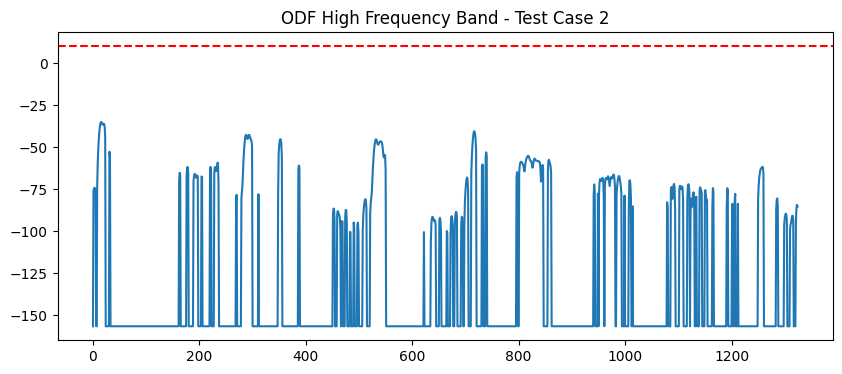

In [50]:
#test case 2

mX, odf = compute_odf("C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/piano.wav", 'blackman', 2047, 4096, 128)

# Ahora puedes graficar sin errores
plt.figure(figsize=(10, 4))
plt.plot(10 * np.log10(odf[:, 1] + eps)) # ODF Banda Alta en dB
plt.axhline(y=10, color='r', linestyle='--')
plt.title("ODF High Frequency Band - Test Case 2")
plt.show()

Banda baja: 1 a 139 (Total: 139)
Banda alta: 140 a 464 (Total: 325)


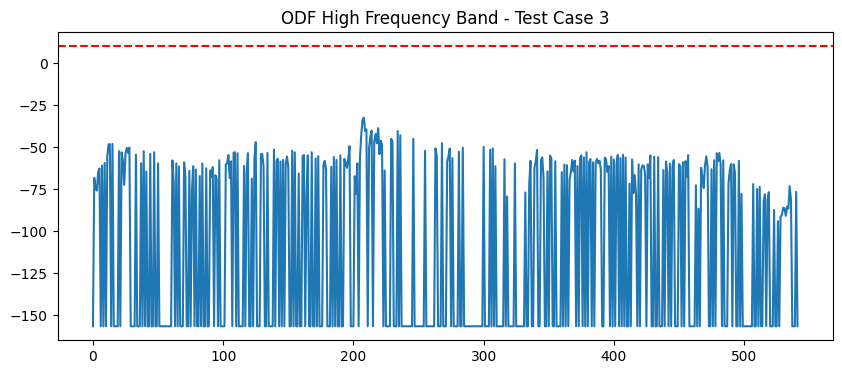

In [52]:
#test case 3

mX, odf = compute_odf(input_file = "C:/Users/marco/Documents/GitHub/sms-tools-materials/sounds/sax-phrase-short.wav", window = 'hamming', M = 513, N = 2048, H= 256)

# Ahora puedes graficar sin errores
plt.figure(figsize=(10, 4))
plt.plot(10 * np.log10(odf[:, 1] + eps)) # ODF Banda Alta en dB
plt.axhline(y=10, color='r', linestyle='--')
plt.title("ODF High Frequency Band - Test Case 3")
plt.show()

**Questions E4 - 4.3:**

### Explain the results of Part 4

The Onset Detection Function (ODF) detects musical attacks by measuring temporal energy differences, where peaks indicate note beginnings.
Using a small window (M = 513) provides high temporal resolution, producing sharp peaks and allowing detection of five piano attacks above 10 dB.
The 3000–10000 Hz band is most effective for piano because the hammer’s percussive impact stands out more than low-frequency harmonics.
A larger window (M = 2047) smooths the signal, reducing peak sharpness and detection precision.
With the saxophone, the less impulsive dynamics show that threshold adjustment is essential depending on the instrument.
Half-wave rectification removes energy decays to focus only on new sound events.
Processing in the linear domain before logarithmic conversion ensures that true attack peaks rise clearly above background noise.